In [1]:
# Imports:

import sys
import os

import chainer
import numpy as np
import matplotlib.pyplot as plot

from chainercv import utils

Import Mask-RCNN implemented by DeNA:

In [2]:
dir_path = os.path.join(os.getcwd(), os.pardir)
os.chdir(dir_path)

In [3]:
abs_maskrcnn = os.path.join(dir_path, 'maskrcnn')
assert os.path.exists(abs_maskrcnn)
sys.path.insert(0, abs_maskrcnn)
try:
    from mask_rcnn_train_chain import MaskRCNNTrainChain
    from mask_rcnn_resnet import MaskRCNNResNet
    from utils.bn_utils import freeze_bn, bn_to_affine
    from utils.vis_bbox import vis_bbox   
except:
    print('Check the path for Mask-RCNN Directory')

## Mask-RCNN

In [4]:
test_class_ids = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, \
    27, 28, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, \
    57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 70, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 84, 85, 86, 87, 88, 89, 90]

coco_label_names = ('background',  # class zero
    'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
    'fire hydrant', 'street sign', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'hat', 'backpack', 'umbrella', 'shoe', 'eye glasses', 'handbag', 'tie', 'suitcase', 'frisbee',
    'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle',
    'plate', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange',
    'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
    'mirror', 'dining table', 'window', 'desk','toilet', 'door', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven',
    'toaster', 'sink', 'refrigerator', 'blender', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
)

In [5]:
roi_size = 14
modelfile = os.path.join(abs_maskrcnn, 'modelfiles/e2e_mask_rcnn_R-50-C4_1x_d2c.npz')
roi_align = True

model = MaskRCNNResNet(n_fg_class = 80,
                       roi_size = roi_size,
                       pretrained_model = modelfile,
                       n_layers = 50,  # resnet 50 layers (not 101 layers)
                       roi_align = roi_align,
                       class_ids = test_class_ids)
chainer.serializers.load_npz(modelfile, model)

MaskRNNResNet initialization
setting initialW
Extractor ResNet 50  initialization
ROI Align= True
MaskRCNN initialization


In [6]:
chainer.cuda.get_device_from_id(0).use()
model.to_gpu()

In [7]:
bn_to_affine(model)

converted batchnorm to affine


In [8]:
image_name = 'static_data/rgb.png'

img = utils.read_image(image_name, color=True)
bboxes, labels, scores, masks = model.predict([img])

In [9]:
bbox, label, score, mask = bboxes[0], np.asarray(labels[0],dtype=np.int32), scores[0], masks[0]

1
62
73
76
77


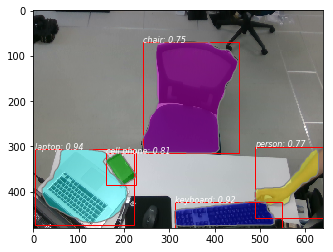

In [10]:
vis_bbox(
    img, 
    bbox, 
    label=label, 
    score=score, 
    mask=mask, 
    label_names=coco_label_names, 
    contour=True, 
    labeldisplay=True
)
plot.show()

### TODO:

- Iterate through label and find corresponding depths point
  - There may be more than one instances per label
- Save as csv (don't care for instances, just location in each frame)


In [11]:
import open3d as o3

In [12]:
depth_image = 'static_data/depth.png'

color = o3.read_image(image_name)
depth = o3.read_image(depth_image)
rgbd_image = o3.create_rgbd_image_from_color_and_depth(color, depth)

In [13]:
depth_arr = np.asarray(rgbd_image.depth)
depth_arr.shape

(480, 640)

In [14]:
# use chair as example:
chair_index = coco_label_names.index('chair')
label_index = label.searchsorted(chair_index)

chair_bbox = bbox[label_index]
chair_mask = mask[label_index]
chair_score = score[label_index]

1


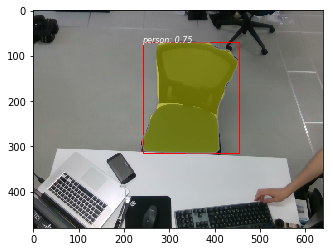

In [15]:
vis_bbox(
    img, 
    [chair_bbox], 
    label=[label_index], 
    score=[chair_score], 
    mask=[chair_mask], 
    label_names=coco_label_names, 
    contour=True, 
    labeldisplay=True
)
plot.show()

In [16]:
from pprint import pprint

In [17]:
pprint(chair_bbox)
print("mask shape", chair_mask.shape)
print(chair_score)

array([ 69.82371, 241.06467, 314.96378, 454.21365], dtype=float32)
mask shape (480, 640)
0.7470091


In [18]:
flatten = chair_mask.flatten()
unique, counts = np.unique(flatten, return_counts=True)
pprint(dict(zip(unique, counts)))
print(sum(counts))

{0: 269115, 1: 38085}
307200


- 0: none
- 1: found

In [19]:
chair_depth = np.multiply(depth_arr, chair_mask)
chair_depth.shape

(480, 640)

In [20]:
flatten = chair_depth.flatten()
unique, counts = np.unique(flatten, return_counts=True)
pprint(dict(zip(unique, counts)))
print(sum(counts))

{0.0: 269872,
 1.537: 1,
 1.541: 1,
 1.543: 2,
 1.548: 1,
 1.55: 1,
 1.554: 2,
 1.556: 1,
 1.559: 1,
 1.561: 8,
 1.563: 8,
 1.565: 4,
 1.567: 4,
 1.57: 4,
 1.572: 2,
 1.574: 5,
 1.576: 3,
 1.579: 3,
 1.581: 2,
 1.583: 2,
 1.585: 6,
 1.588: 62,
 1.59: 136,
 1.592: 141,
 1.594: 184,
 1.597: 116,
 1.599: 102,
 1.601: 113,
 1.604: 162,
 1.606: 137,
 1.608: 172,
 1.611: 175,
 1.613: 256,
 1.615: 400,
 1.618: 527,
 1.62: 573,
 1.622: 414,
 1.625: 398,
 1.627: 357,
 1.63: 380,
 1.632: 342,
 1.634: 270,
 1.637: 277,
 1.639: 290,
 1.642: 331,
 1.644: 348,
 1.646: 267,
 1.649: 270,
 1.651: 303,
 1.654: 331,
 1.656: 579,
 1.659: 361,
 1.661: 303,
 1.664: 208,
 1.666: 182,
 1.669: 229,
 1.671: 247,
 1.674: 255,
 1.676: 247,
 1.679: 240,
 1.681: 340,
 1.684: 322,
 1.687: 259,
 1.689: 213,
 1.692: 214,
 1.694: 220,
 1.697: 310,
 1.699: 209,
 1.702: 185,
 1.705: 221,
 1.707: 209,
 1.71: 163,
 1.713: 175,
 1.715: 164,
 1.718: 202,
 1.721: 196,
 1.723: 214,
 1.726: 235,
 1.729: 242,
 1.731: 226,
 1.734

Multiplied the mask with depth data to get just the chair's depth data.

Note: there are more zeros in depth data since zero in depth data means depth data for the pixel was unobtainable.

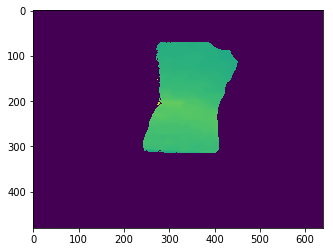

In [21]:
plot.imshow(chair_depth)